# Introduction

This notebook presents my attempt to the use of neural network designed with [Keras](https://keras.io/). <br>

This work is inspired by the [Kaggle Dog Breed Identification Challenge](https://www.kaggle.com/c/dog-breed-identification)(I did not take part in the competition because it was too late to submit). However, being a doggo friend, I enjoyed the topic and wanted to take the opportunity to improve my skills in computer vision! So, I took a dog breed identification dataset and built my own classifier and aimed to use it to identify the breed of dogs in general.<br>

As specified on Kaggle: <i>You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo. </i><br><br>
The dataset is composed of 133 different breeds with 8350 pictures in total. The number of pictures per breed goes roughly from 25 to 100. <br><br>

Then, it's not enough to train a neural network. It will overfit the images and so the error on the test set will be high. <br> 
To deal with it, I will apply the two methodologies: 
 - Data augmentation of the training set: I apply several transformations in the training set images in order to create new images with the same label. It will make the CNN more robust to any small variation in the images.
 - I'll use a pre-trained neural net, use it as the first part our my classifier and modify it to fit in this problem.

<u>Remark:</u> Because of the lack of power resource (especially I don't have GPU), I wasn't able to run the code and get the results with a great accuracy. However, this code works perfectly well and it will be possible to select the best model once trained on GPU. 

# Imports

In [53]:
#for navigation in the folders
import os

#for plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#image reading
from scipy.misc import imresize
from scipy.misc import imshow
from scipy.misc import toimage
from scipy.misc import imread

#spliting dataset 
from sklearn.model_selection import train_test_split

#data augmentation
from keras.preprocessing.image import ImageDataGenerator

#model 
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

from keras import layers, models, regularizers, optimizers
from keras.models import Sequential,  Model
from keras.layers import Flatten, Dense, Dropout


import numpy as np
import pandas as pd
import seaborn as sns 
import PIL
import pickle
from time import strftime


# Navigation in folders and building of the dataset

## Navigation in folders

In [54]:
data_dir = "/complete/"
directory = os.getcwd() + data_dir # path to the files
files_tags = os.listdir(directory) #these are the differents pdf files

#this is here because hidden files are also shown in the list. 
for file in files_tags:
    if file[0] == '.':
        files_tags.remove(file)
classes = [file.split('.')[1] for file in files_tags]
print('There are {} different breeds.'.format(len(classes)))

There are 133 different breeds.


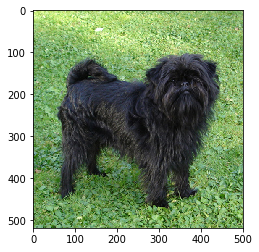

In [55]:
# Example of a Affenpinscher picture
im = imread(directory + "001.Affenpinscher/Affenpinscher_00056.jpg")
plt.imshow(im)
#im = imresize(im,(2000, 2000, 3)) # We reduce the quality of the picture in order to make it lighter
#plt.imshow(im)

All the image have different size. Let's see the distribution of the size

In [56]:
list_size_x = list()
list_size_y = list()
for tag in files_tags:
    #navigate in all the breed labels
    path_to_breed = directory + tag
    #get all the images per breed
    images_name = os.listdir(path_to_breed)
    for image in images_name:
        path_to_image = path_to_breed+'/'+image
        im = imread(path_to_image)
        try:
            list_size_x.append(im.shape[0])
            list_size_y.append(im.shape[1])
        except:
            print('Problem with', path_to_image)
        
    

Problem with /Users/Selim/Desktop/Prez Quantiphi/complete/098.Leonberger/Leonberger_06571.jpg


In [57]:
print(min(list_size_x), np.mean(list_size_x), max(list_size_x), min(list_size_y), np.mean(list_size_y), max(list_size_y))

113 529.0162874251497 4003 105 566.9778443113772 4278


All the images doen't have the same shape. We will reshape all the image to fit in the square image of giver size. 

In [58]:
#len(list_size_x) is the number of images. 
print('There are ', len(list_size_x), 'images in the dataset.')
size_image = 100 #lower than the min of the pictures.
print('The images will be re-shaped to a size of ', size_image, 'pixels per side.')
size = (len(list_size_x), size_image, size_image, 3)
matrix_image = list()#np.zeros(size)
list_breed = list()#np.zeros(len(list_size_x))
size

There are  8350 images in the dataset.
The images will be re-shaped to a size of  100 pixels per side.


(8350, 100, 100, 3)

In [59]:
#c=0
for tag in files_tags:
    #navigate in all the breed labels
    path_to_breed = directory + tag
    #get all the images per breed
    images_name = os.listdir(path_to_breed)
    for image in images_name:
        try:
            path_to_image = path_to_breed+'/'+image
            im = PIL.Image.open(path_to_image) # open colour image
            im = im.resize((size_image, size_image))
            im = np.array(im)
            #normalization of the pixels 
            im = np.clip(im/255.0, 0.0, 1.0) #255 = max of the value of a pixel
            matrix_image.append(im)#[c]=im
            list_breed.append(tag.split('.')[1])#[c] = tag.split('.')[1]
            #c+=1

        except:
            print('Problem with', path_to_image)

        

Problem with /Users/Selim/Desktop/Prez Quantiphi/complete/098.Leonberger/Leonberger_06571.jpg


We save the data to not having to run all the code each time. 

In [60]:
pickle.dump(matrix_image, open( 'data_breed' + '.p', "wb" ) )
pickle.dump(list_breed, open( 'list_breed' + '.p', "wb" ) )

In [61]:
data_breed = pickle.load( open( "data_breed.p", "rb" ) )
list_breed = pickle.load( open( "list_breed.p", "rb" ) )

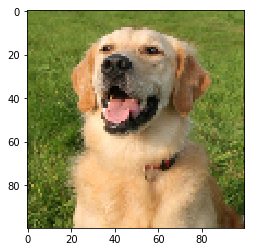

In [4]:
#example
img = data_breed[1231]
plt.imshow(img)

## Set up of the input matrix

In [5]:
#all the processed images
X_all = np.array(data_breed)
#all the label corresponding to the image
Y_all = np.array(list_breed)
print(len(X_all), len(Y_all))

8350 8350


In [6]:
#Then, we one hot encode 
#to do that, we will use a pandas function
df = pd.DataFrame(Y_all) 
u = pd.get_dummies(df, prefix= None)
Y_all = u.as_matrix()

In [7]:
set_breed = set(list_breed)
nb_label = len(set_breed)
print('There are ', nb_label, 'different labels.')

There are  133 different labels.


In [8]:
#spliting the dataset between training, testing and validation
#we use the stratified method in order to preserve the ratio of each class

#we take the training set
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all,
                                                stratify=Y_all, 
                                                test_size=0.2)

#here we split the remaining in 2 between test and validation set
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test,
                                                stratify=Y_test, 
                                                test_size=0.5)

#the splitting in deep learning is different than in conventional machine learning. 
# the neural network performs better with a lot a data, so we need to feed it with the maximum number 



#train set: used to train the NN 
#test set: used to evaluate the performance of the dataset 
#validation set: used at the very end to valid the accuracy of the NN and also to compare
#different NN.

In [9]:
print(len(X_train), len(X_test), len(X_val))

6680 835 835


In [10]:
X_train[0].shape

(100, 100, 3)

# CNN architecture

## Remark on the dataset 

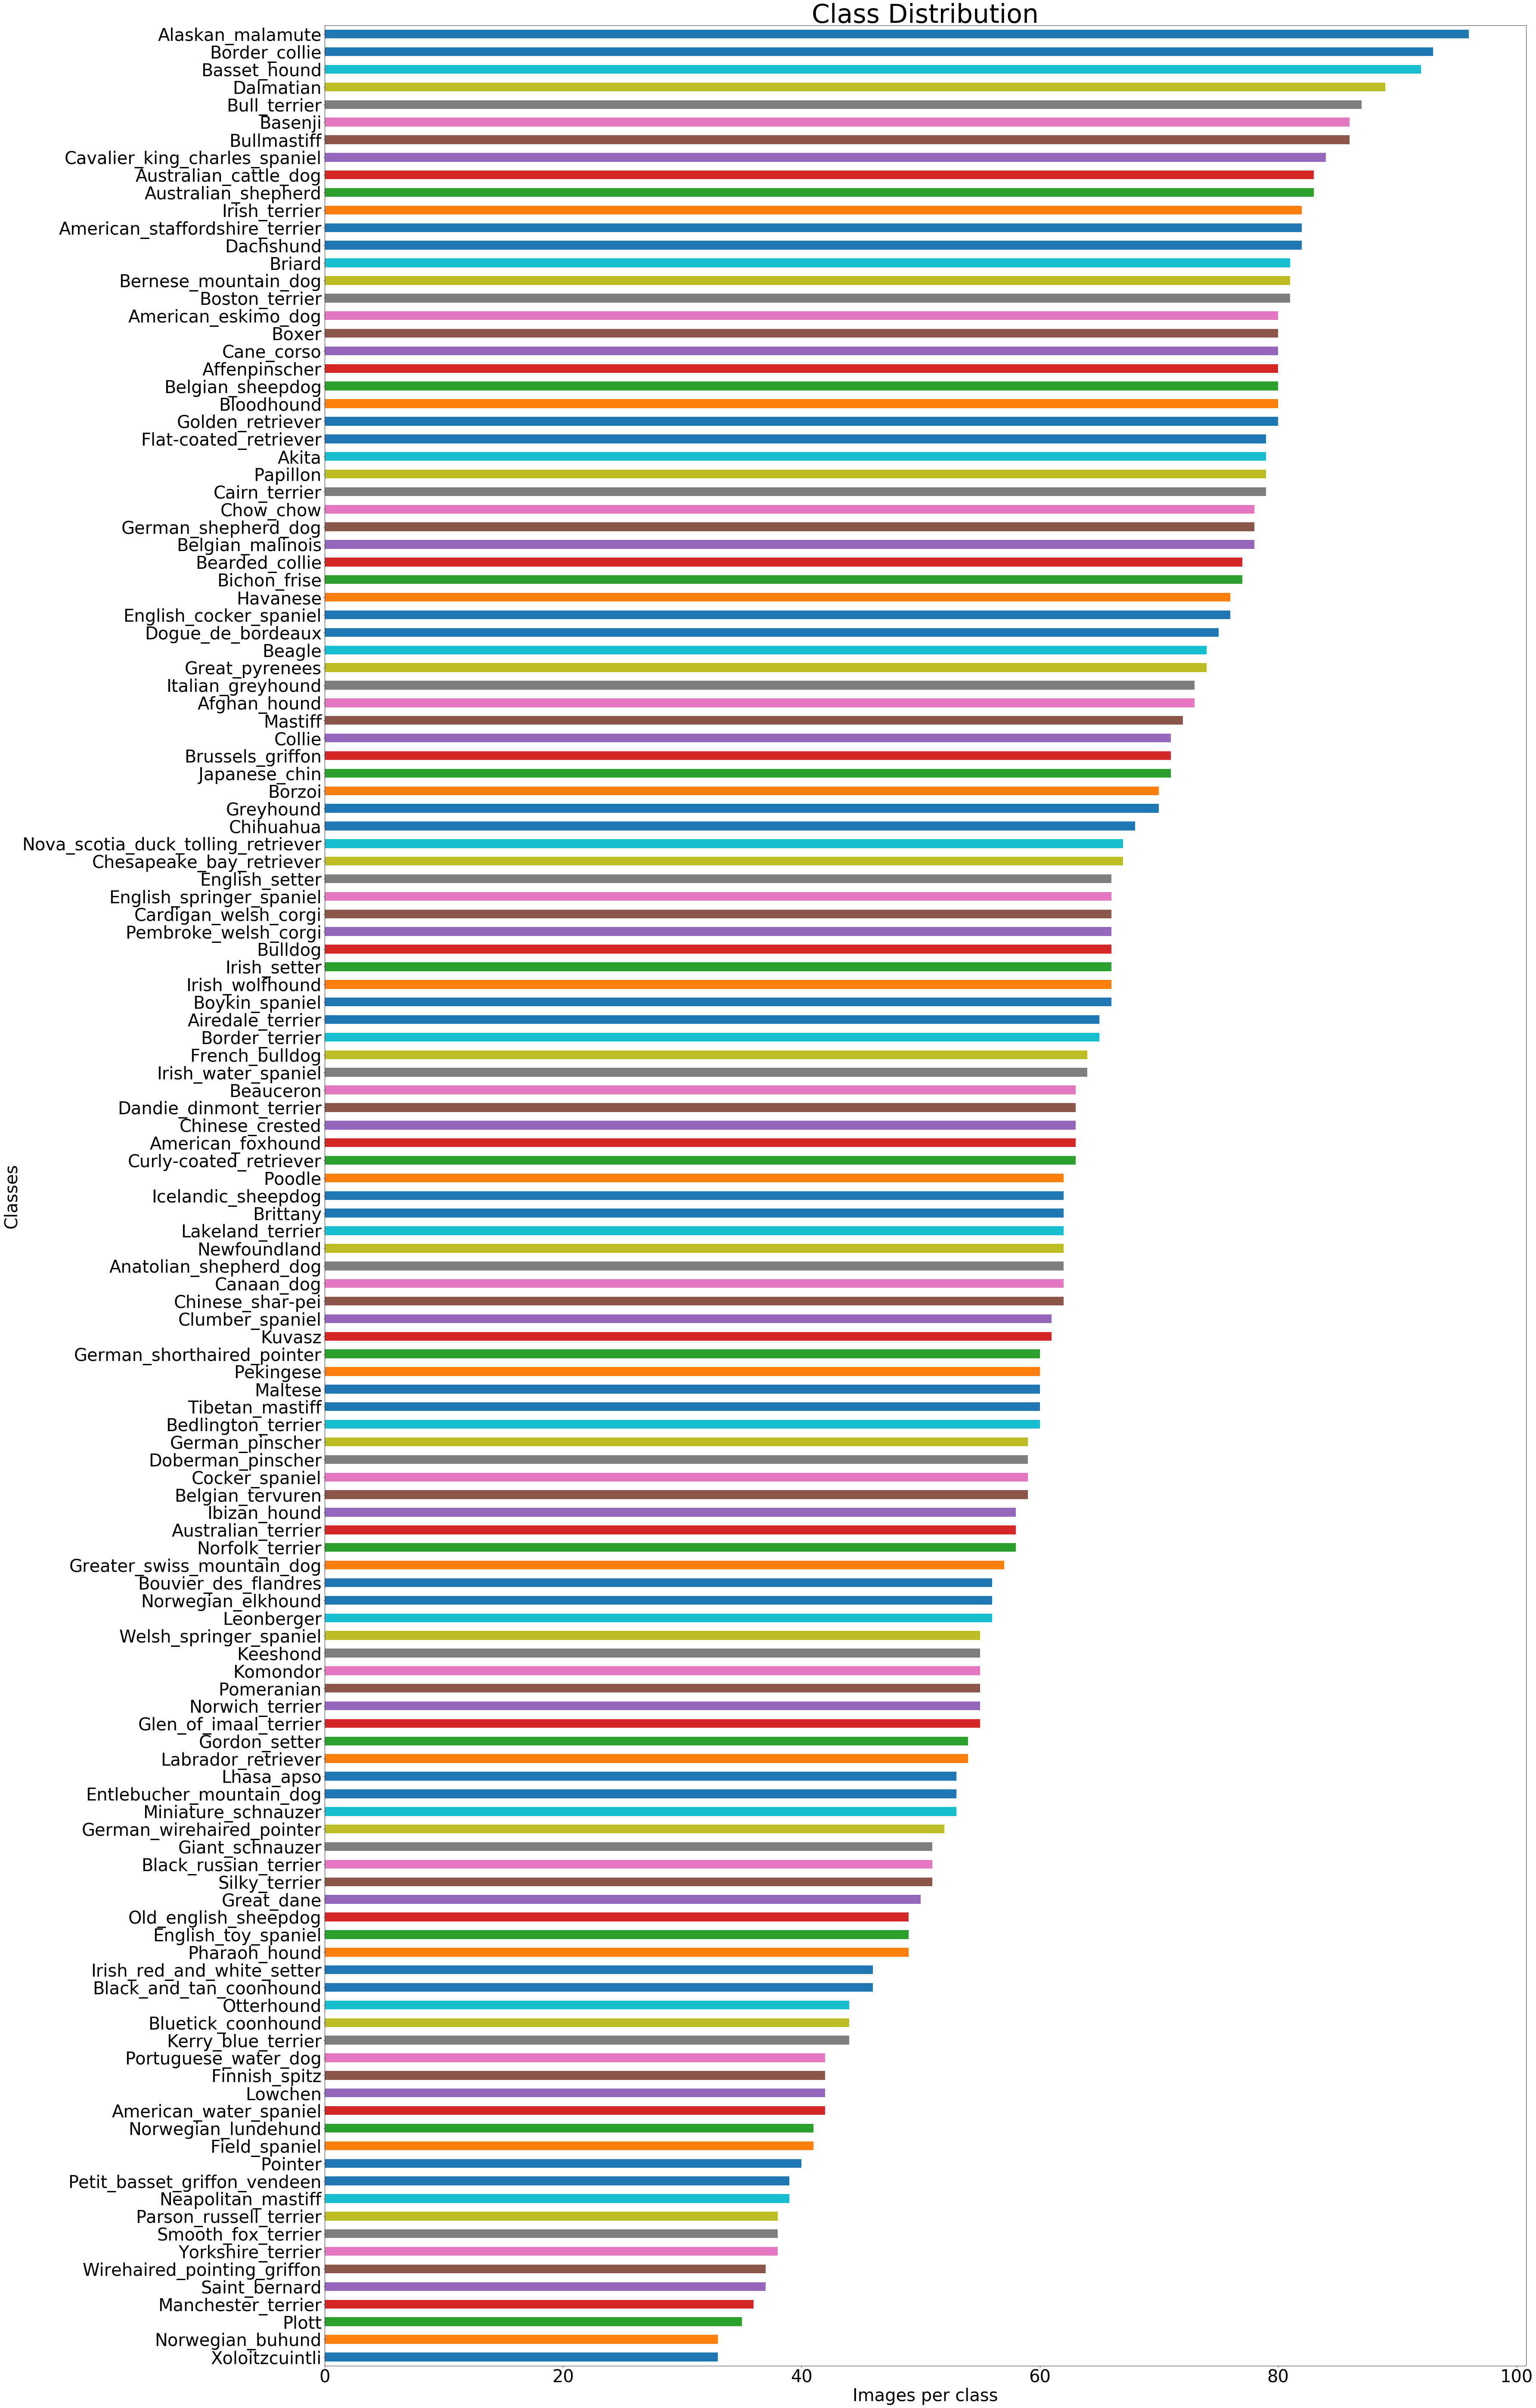

In [63]:
# Take a look at the class/breed distribution
ax=pd.value_counts(list_breed,ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Class Distribution",
                                                       figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.savefig('labels')
plt.show()

The number of breeds is to high compared to the number of images we have. So, the number of images par label is too small (roughly 80). Thus, it's not enough to train a neural network. It will overfit the images and so the error on the test set will be high. We can employ different strategies to deal with this problem:
 - Label dimension reduction: we reduce the number of breeds by grouping different labels under the same name. This could work, however, I am not an expert in dogs, and so I can't figure out the good clusters of breeds.
 - Use other database to get more data (example: ImageNet): problem we are not sure these images are already coming from ImageNet, so we won't add any new data.
 - Data augmentation of the training set: we apply several transformation in the training set images in order to create new images with the same label. It will make the CNN more robust to any small variation in the images.
 - Use a pre-trained neural net and modify it to fit in our label problem.

## Training data augmentation

We can operate several operations to augment the number of images. Moreover, the customer is not a professional photographer, so this kind of transformation is necessary to add robustness to the 'amateurism' of the photo:
- Scaling: dog can be big or small 
- Translation: dog is not well in the middle of the picture
- Rotation(90 degree): Let's take the example of smartphone, there are commonly 3 different angles to take the picture (vertical, or horizontal both side). it's done with the flipping
- Rotation (range of angles): we do it to traduce the fact the customer won't be perfectly vertical when taking the picture. But we won't take a too big range because it creates a black background.
- Adding Salt and Pepper noise: some white and black pixels are add to mimic the unperfectness of a user's camera. (need to be done to improve the model)
- Lighting condition: really important because the lightning changes a lot following the picture conditions. (need to be done to improve the model)

Practically, we use the keras train generator built-in function. 

In [12]:
# Create train generator.
datagen = ImageDataGenerator(
    rotation_range=15,#small angle for rotation
    zoom_range = 0.4, #for scalling
    width_shift_range=0.3,#translation
    height_shift_range=0.3,#translation
    horizontal_flip= True, #90 degree rotation
    vertical_flip = True #90 degree rotation
)

# example of train generator will train the model taking a batch size
#we don't build a giant alterated image set for memory saving
train_generator = datagen.flow(
    X_train, Y_train, shuffle=False, batch_size=9)

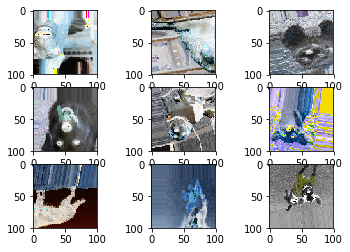

In [13]:
#example of the transformation
for X_batch, y_batch in train_generator:
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(255*X_batch[i]) #multplied by 255 to de-normalized the data
    plt.show()
    break

So, now, we can build augmented data for the model.

## Model 

To build our model we can do:
- build from scratch a CNN model
- use a pre-trained model, then customize last layers

Because of the previous reason and the low number of data, we will use a pre-trained model. 

Pre-trained are here advantageous because:
- we don't have a huge amount of labeled data, so we'll get approximate value of the parameters of the NN
- save computational time (especially if you don't have access to fast computation ressources).

With keras, we can have access to several models (example):
- AlexNet
- VGGNet
- Inception
- ResNet
- Xception
- MobileNet
- SqueezeNet

Our final architecture is:
 - One pre-trained model (CNN part belongs to it)
 - One flatten layer
 - One hidden layer 
 - One output layer 

## Pre-trained part

In [14]:
#we will use these 2 models 
list_model = [Xception, VGG16]

def nn_conv_base(model_base):
    """
    this function define the pre-trained part of the model.
    the weights can't be changed.
    """
    conv_base = model_base(weights='imagenet',
                     include_top=False,
                     input_shape=(size_image, size_image, 3))
    conv_base.trainable = False
    
    return conv_base
    
#nn_conv_base(Xception)

## Customized Part

In [17]:
def full_model(model_base, nb_hidden_layer = 512, hidden_activation = 'relu', 
               final_activation = 'sigmoid', nb_class =  nb_label, 
               loss = 'categorical_crossentropy',optimizer = 'adam' ):
    """
    This function build the whole model, based on the pre-trained model.
    """
    model = models.Sequential()
    model.add(nn_conv_base(model_base))
    model.add(layers.Flatten())
    model.add(layers.Dense(nb_hidden_layer, activation=hidden_activation))
    model.add(layers.Dense(nb_class, activation='sigmoid'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['acc'])
    return model

In [25]:
#example
model = full_model(list_model[0])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 30,367,405
Trainable params: 9,505,925
Non-trainable params: 20,861,480
_________________________________________________________________


# Training of the model 

## Parameters

In [42]:
train_batch_size = int(len(X_train)*0.1)
test_batch_size = int(len(X_test)*0.3)
nb_epochs = 10


total_train_image = len(X_train)
total_test_image= len(X_test)

steps_per_epoch=1#int(total_train_image / batch_size)
validation_steps = 1#int(total_test_image / batch_size)

## Train Generator 

In [43]:
#we already specify the train_generator

train_generator = datagen.flow(
    X_train, Y_train, shuffle=False, batch_size=train_batch_size)


#we need a validation generator which do nothing except taking picture from test set 

datagen_test = ImageDataGenerator()


validation_generator = datagen_test.flow(
    X_test, Y_test, shuffle=False, batch_size=test_batch_size)

## Training of Xception

In [44]:
model_xception = full_model(list_model[0])


history_xception = model_xception.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=nb_epochs,
      validation_data=validation_generator,
      validation_steps=validation_steps
)

time_str = strftime("%Y%m%d_%H%M%S")
model_xception.save('dog_breed_pretrain_xception_{}.h5py'.format(time_str))

Epoch 1/10
1/1 [==============================] - 92s 92s/step - loss: 4.9038 - acc: 0.0090 - val_loss: 5.4415 - val_acc: 0.0240
Epoch 2/10
1/1 [==============================] - 70s 70s/step - loss: 4.9701 - acc: 0.0150 - val_loss: 5.5438 - val_acc: 0.0120
Epoch 3/10
1/1 [==============================] - 69s 69s/step - loss: 4.9660 - acc: 0.0150 - val_loss: 5.4872 - val_acc: 0.0200
Epoch 4/10
1/1 [==============================] - 54s 54s/step - loss: 4.9359 - acc: 0.0150 - val_loss: 5.2200 - val_acc: 0.0353
Epoch 5/10
1/1 [==============================] - 62s 62s/step - loss: 4.9236 - acc: 0.0090 - val_loss: 5.1106 - val_acc: 0.0200
Epoch 6/10
1/1 [==============================] - 67s 67s/step - loss: 4.9061 - acc: 0.0030 - val_loss: 4.9408 - val_acc: 0.0080
Epoch 7/10
1/1 [==============================] - 64s 64s/step - loss: 4.8645 - acc: 0.0105 - val_loss: 4.9847 - val_acc: 0.0120
Epoch 8/10
1/1 [==============================] - 60s 60s/step - loss: 4.8559 - acc: 0.0120 - val

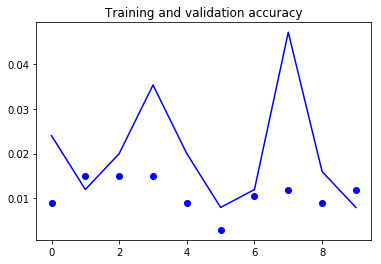

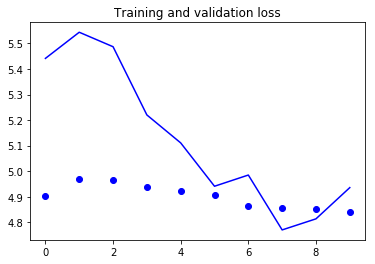

In [45]:
acc = history_xception.history['acc']
val_acc = history_xception.history['val_acc']
loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')

plt.show()

After an hour of training, we went from 1% to 15% of accuracy which is much more than 1/133 (nb of labels). So, with more training time we can go to a better accuracy. 

## Training of VGG16

In [46]:
#for this one, only 2 epochs to show it works.I don't have time to run it longer. 
model_VGG16 = full_model(list_model[1])

history_VGG16 = model_VGG16.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=nb_epochs,
      validation_data=validation_generator,
      validation_steps=validation_steps
)

time_str = strftime("%Y%m%d_%H%M%S")
model_VGG16.save('dog_breed_pretrain_VGG16_{}.h5py'.format(time_str))

Epoch 1/10
1/1 [==============================] - 530s 530s/step - loss: 4.9679 - acc: 0.0030 - val_loss: 4.9048 - val_acc: 0.0040
Epoch 2/10
1/1 [==============================] - 453s 453s/step - loss: 4.9212 - acc: 0.0045 - val_loss: 4.9305 - val_acc: 0.0040
Epoch 3/10
1/1 [==============================] - 392s 392s/step - loss: 4.9585 - acc: 0.0075 - val_loss: 4.9153 - val_acc: 0.0080
Epoch 4/10
1/1 [==============================] - 370s 370s/step - loss: 4.9275 - acc: 0.0045 - val_loss: 4.9052 - val_acc: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 465s 465s/step - loss: 4.8915 - acc: 0.0150 - val_loss: 4.8167 - val_acc: 0.0080
Epoch 6/10
1/1 [==============================] - 433s 433s/step - loss: 4.8868 - acc: 0.0060 - val_loss: 4.8877 - val_acc: 0.0120
Epoch 7/10
1/1 [==============================] - 453s 453s/step - loss: 4.8675 - acc: 0.0135 - val_loss: 4.8484 - val_acc: 0.0120
Epoch 8/10
1/1 [==============================] - 401s 401s/step - loss: 4.8978

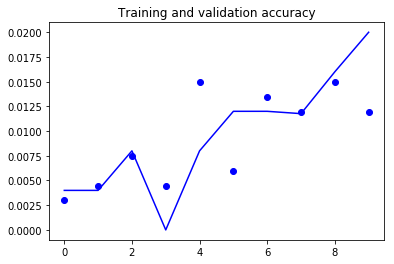

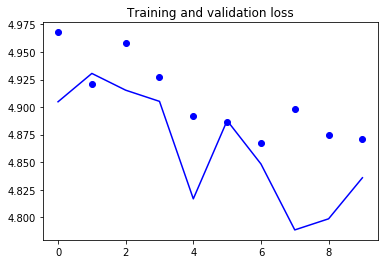

In [47]:
acc = history_VGG16.history['acc']
val_acc = history_VGG16.history['val_acc']
loss = history_VGG16.history['loss']
val_loss = history_VGG16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')

plt.show()

# Evaluation

We use the Validation Dataset to get the accuracy of the 2 models on a completely new dataset. This value will be the real value of the model. Then, we'll be able to select the model for the prediction part. 

In [48]:
score_xception = model_xception.evaluate(X_val, Y_val, verbose=0)

In [49]:
print('The global accuracy on validation set with XCeption is', round(score_xception[1]*100,2), '%')

The global accuracy on validation set with XCeption is 1.8 %


In [50]:
score_VGG16 = model_VGG16.evaluate(X_val, Y_val, verbose=0)

In [51]:
print('The global accuracy on validation set with VGG16 is', round(score_VGG16[1]*100,2), '%')

The global accuracy on validation set with VGG16 is 2.63 %


# Prediction from the customer's picture

In [38]:
def dog_breed_prediction(path_to_image, model):
    im = imread(path_to_image)
    im = imresize(im,(size_image, size_image, 3))
    y = model.predict(im)
    index_max = y.index(max(y))
    print( "breed predicted: " + set_breed[index_max] + "Prob: " + string(y[index_max]))
    return set_breed[index_max], string(y[index_max])

# Conclusion

As we saw, it is possible to build a neural network to identify the breed of dogs. <br>

We can imagine also from a picture the age (at least young/old, given we already know the breed), the gender and the presence of diseases. From this informations, the insurance company will be able to do a better pricing of the insurance plan.<br>
Technically, we can improve the model through:
- Because there are many breeds, it generate inaccuracy. Therefore, we can imagine to reduce the number of labels to get a better accuracy. Indeed, from an insurance point of view, maybe there are already clustering the dogs in different groups. So, we can do the same clusters.
- Because, we don't have many images per label, we can enhance the dataset with more pictures from public or even private(the insurance's one) dataset. 
- We tried only 2 models, other can be used. 
- We did not use all the method to augment the number of image (salt and pepper, lightning...)
- We can improve the architecture(more layers, more neurons per layer) of the customized part of the network or even build a network from scratch.